LAB BOOK

As we didn't get priority for time at the alluna telescope, we decided to use archival data for our target to do the data reduction. We used the provided data on our canvas page and the target is Abell 2319. We noticed that there only 5 bias frames so this could cause some issue for the bias subtraction portion of our work. First we imported relevant packages. Then we added a name to our varies file paths for the bias, dark and flat files. (We realised that we didn't have any dark frames in aour original archival data from Abell 2319, so we used dark frames from the Deep Extragalactic Field dataset.)

In [92]:
import numpy as np # importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import astropy 
from astropy.nddata import CCDData
import ccdproc # able to import ccdproc after having some issue with installing and running package
from ccdproc import combine, subtract_bias
from ccdproc import subtract_dark
import os
import glob
from astropy.io import fits
from astropy import units as u
from photutils.aperture import CircularAperture
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.datasets import make_100gaussians_image
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import deblend_sources
import photutils
from photutils.segmentation import SourceCatalog
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
import scipy.stats as stats

BIAS SUBTRACTION

In [93]:
#READING IN THE BIAS DARK AND FLAT FRAMES.

biasfitspath = r"U:\Lab Book\Abell2319\bias\*.fits"
biaslist2319 = glob.glob(biasfitspath)

bias2319data = [astropy.nddata.CCDData.read(bframe, unit = 'adu') for bframe in biaslist2319] # reads all bias frames in the bias folder

#-----------------------------------------------------------------------------------------------------------------------------------------

darkfitspath = r"U:\Lab Book\Abell2319\darks\*.fits"
darklist2319 = glob.glob(darkfitspath)

#-----------------------------------------------------------------------------------------------------------------------------------------

flatfitspathB = r"U:\Lab Book\Abell2319\flat_B\*.fits"
flatfitspathR = r"U:\Lab Book\Abell2319\flat_R\*.fits"
flatBlist2319 = glob.glob(flatfitspathB)
flatRlist2319 = glob.glob(flatfitspathR)

#-----------------------------------------------------------------------------------------------------------------------------------------
#NOW I'M SUBTRACTING MASTER BIAS FROM DARK AND FLAT FRAMES TO CREATE A MASTER DARK AND THEN MASTER FLATS FOR EACH COLOUR FILTER

mastbi2319Frame = ccdproc.combine(bias2319data, method = 'median')
darkbias2319frame = ccdproc.combine([subtract_bias(CCDData.read(d2319frame, unit='adu'), mastbi2319Frame) for d2319frame in darklist2319], method='median') 

flatbiassubB = [subtract_bias(CCDData.read(fBframe, unit = 'adu'), mastbi2319Frame) for fBframe in flatBlist2319] #subtracted master bias frame from all the flat frames in B filter
flatbiassubR = [subtract_bias(CCDData.read(fRframe, unit = 'adu'), mastbi2319Frame) for fRframe in flatRlist2319] #subtracted master bias frame from all the flat frames in R filter
#, exposure_time = 'EXPTIME', exposure_unit = u.second, scale = True


While doing the bias subtraction segment of our data reduction, we came across an issue with our original dark frames taken from Deep Extragalactic Field dataset. The data shapes didn't match, hence we couldn't actually subtract the master bias frame from the dark frames unless we cropped the bias frames but that's not optimal for our data reduction. So we then decided to use the Solar System Debris dataset for Asteroid 694 Ekard, which has dark frames but the zip file was very big and downloading and extracting took up too much space on my network drive so i could only use 5 dark frames. This works against me as using more dark frames can result in a better master dark quality, better noise reduction and is effective for fainter objects.

DARK SUBTRACTION

In [94]:
for f in flatRlist2319:
    flat = CCDData.read(f, unit = 'adu')
    print(f"{f}: EXPTIME = {flat.header['EXPTIME']} s")

U:\Lab Book\Abell2319\flat_R\20181111.flat.00000028.fits: EXPTIME = 14.0 s
U:\Lab Book\Abell2319\flat_R\20181111.flat.00000029.fits: EXPTIME = 14.0 s
U:\Lab Book\Abell2319\flat_R\20181111.flat.00000030.fits: EXPTIME = 14.0 s
U:\Lab Book\Abell2319\flat_R\20181111.flat.00000031.fits: EXPTIME = 17.0 s
U:\Lab Book\Abell2319\flat_R\20181111.flat.00000032.fits: EXPTIME = 20.0 s


In [95]:
# NOW SUBTRACTING THE MASTER DARK FRAME FROM THE FLAT FRAMES IN THE R AND B BANDS AND THEN NORMALISING THEM


fbdsubB = [subtract_dark(b, darkbias2319frame, exposure_time = 'EXPTIME', exposure_unit = u.second, scale = True) for b in flatbiassubB]

flats_R_14s = [r for r in flatbiassubR if r.header['EXPTIME'] == 14.0]
flats_R_17s = [r for r in flatbiassubR if r.header['EXPTIME'] == 17.0]
flats_R_20s = [r for r in flatbiassubR if r.header['EXPTIME'] == 20.0]

fbdsubR14 = [subtract_dark(r, darkbias2319frame, exposure_time = 'EXPTIME', exposure_unit = u.second, scale = True) for r in flats_R_14s]
fbdsubR17 = [subtract_dark(r, darkbias2319frame, exposure_time = 'EXPTIME', exposure_unit = u.second, scale = True) for r in flats_R_17s]
fbdsubR20 = [subtract_dark(r, darkbias2319frame, exposure_time = 'EXPTIME', exposure_unit = u.second, scale = True) for r in flats_R_20s]

#------------------------------------------------------------------------------------------------------------------------------------------
    
meancountsflatB = np.median(fbdsubB)
normflatB = flat.divide(meancountsflatB)


def normalize_flatR(flatRlist2319):
    normalizedR = []
    for f in flatRlist2319:
        median_val = np.median(f.data)
        normalized_data = f.data / median_val
        # Wrap back into CCDData to preserve units
        normalizedR.append(CCDData(normalized_data, unit=f.unit))
    return normalizedR

norm_fbdsubR14 = normalize_flatR(fbdsubR14)
norm_fbdsubR17 = normalize_flatR(fbdsubR17)
norm_fbdsubR20 = normalize_flatR(fbdsubR20)

all_norm_R = norm_fbdsubR14 + norm_fbdsubR17 + norm_fbdsubR20

master_flat_R = ccdproc.combine(all_norm_R, method='median')


BIAS AND DARK SUBTRACTION FROM SCIENCE FRAME AND APPENDING TO A LIST

In [96]:
#CALLING IN SCIENCE FRAMES FOR ABELL 2319 AND APPENDING TO A LIST

scienceBpath = r"U:\Lab Book\Abell2319\science_B\*.fits"
scienceBlist = glob.glob(scienceBpath)

scienceRpath = r"U:\Lab Book\Abell2319\science_R\*.fits"
scienceRlist = glob.glob(scienceRpath)

#----------------------------------------------------------
#CREATING THE CALIBRATED BACKGROUND FRAMES FOR B SCIENCE AND R SCIENCE FRAMES

calibrated_framesB = []

for sBfile in scienceBlist:
    sciB = CCDData.read(sBfile, unit='adu')
    
    # Subtract bias
    bias_subB = subtract_bias(sciB, mastbi2319Frame)
    
    # Scale dark to science exposure
    dark_exposure = darkbias2319frame.header['EXPTIME'] * u.second
    t_sciB = sciB.header['EXPTIME'] * u.second
    scaled_darkB = darkbias2319frame.multiply(t_sciB / dark_exposure)
    
    # Subtract scaled dark
    dark_subB = bias_subB.subtract(scaled_darkB)
    
    # Divide by normalized flat
    flat_correctedB = dark_subB.divide(normflatB)
    
    calibrated_framesB.append(flat_correctedB)


#----------------------------------------------------------------------------

calibrated_framesR = []

for sRfile in scienceRlist:
    sciR = CCDData.read(sRfile, unit='adu')
    
    # Subtract bias
    bias_subR = subtract_bias(sciR, mastbi2319Frame)
    
    # Scale dark to science exposure
    dark_exposure = darkbias2319frame.header['EXPTIME'] * u.second
    t_sciR = sciR.header['EXPTIME'] * u.second
    scaled_darkR = darkbias2319frame.multiply(t_sciR / dark_exposure)
    
    # Subtract scaled dark
    dark_subR = bias_subR.subtract(scaled_darkR)
    
    # Divide by normalized flat
    flat_correctedR = dark_subR.divide(master_flat_R)
    
    calibrated_framesR.append(flat_correctedR)


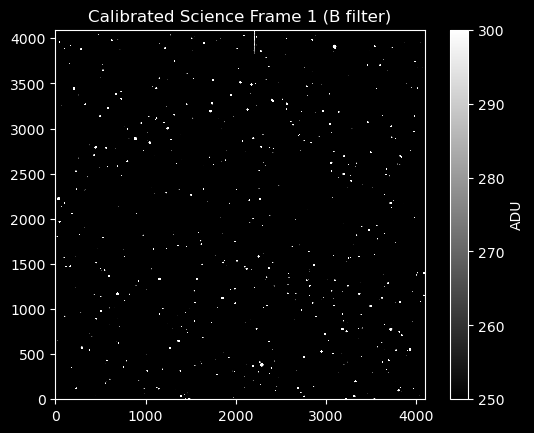

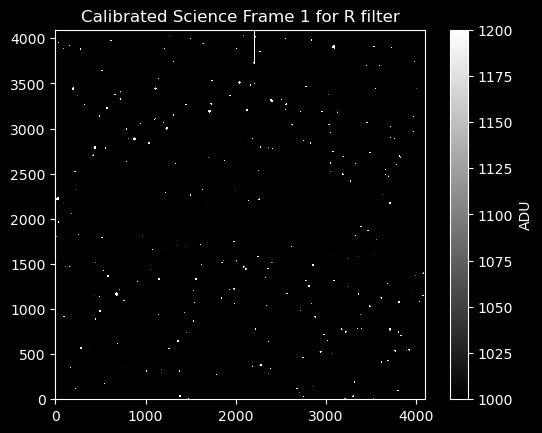

In [97]:
#PLOTTING THE 1ST CALIBRATED FRAME FOR B AND R FILTERS

frame_135B = calibrated_framesB[0]  # Already bias-dark-flat corrected
#vmin = 250 vmax = 300
#vmin, vmax = np.percentile(frame_135B.data, (1, 99))  # clip extremes
plt.imshow(frame_135B.data, cmap='gray', origin='lower', vmin=250, vmax=300)
plt.colorbar(label='ADU')
plt.title('Calibrated Science Frame 1 (B filter)')
plt.show()


frame_135R = calibrated_framesR[0]
#vmin = 700, vmax = 900
#vmin, vmax = np.percentile(frame_135R.data, (1, 99))  # clip extremes
plt.imshow(frame_135R.data, cmap='gray', origin='lower', vmin=1000, vmax=1200)
plt.colorbar(label='ADU')  
plt.title('Calibrated Science Frame 1 for R filter')
#plt.savefig("calibrated_frame135.pdf")
plt.show()


SOURCE EXTRACTION  FOR THE B-FILTER

In [98]:
#GETTING IMAGE DIMENSIONS

dataB = frame_135B.data
# Get the shape (dimensions)
print("Image dimensions:", dataB.shape)

Image dimensions: (4096, 4096)


This is so we know what box size we would need when we create the background Image. It has to be a multiple of 4096 and not too small or big. If the box is too small, the resulting background map will be too noisy with artificial fluctuations. If the box size is too big we might smooth over real background variations, like scattered light gradients or vignetting. Small scale changes, like near bright stars or extended galaxy halos, will be missed.

In [99]:
#BASIC STATISTICS
#1.
meanB0, medianB0, stdB0 = sigma_clipped_stats(dataB, sigma=3.0)
print(np.array((meanB0, medianB0, stdB0)))

#-------------------------------------------------------------------------
#2.
sigma_clip = SigmaClip(sigma=3.0, maxiters=20) #creates sigma clipping object
thresholdB = detect_threshold(dataB, nsigma=2.0, sigma_clip=sigma_clip) #creates detection threshold 2 sigma above background using sigma clipping
segment_imgB = detect_sources(dataB, thresholdB, npixels=20) #creates segmentation map for all detected sources, flux above threshold.

footprint = circular_footprint(radius=10) # next 2 lines make sure galaxies dont contaminate background estimate.
mask = segment_imgB.make_source_mask(footprint=footprint)

meanB1, medianB1, stdB1 = sigma_clipped_stats(dataB, sigma=5.0, mask=mask)
print(np.array((meanB1, medianB1, stdB1)))

[203.42274071 203.12472266  42.38834052]
[202.7515077  202.67640984  41.78127753]


At point 1, I perform a mean median and standard deviaton of the image using sigma clipping, first without masking.

At point2, I do the same thing but using the mask i have created.

I do this for both filters.

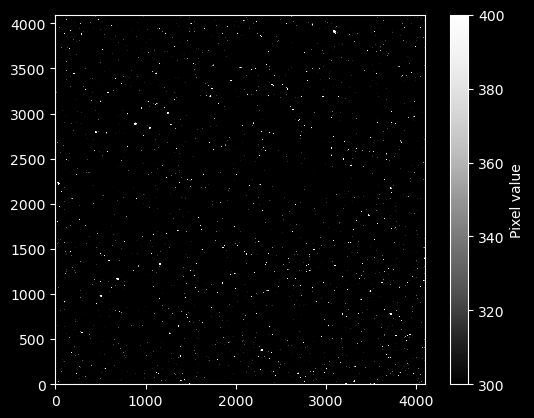

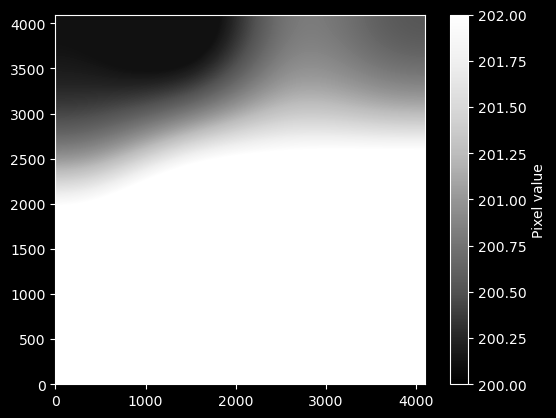

The Background Median for the B-Filter is 202.568
The Background RMS for the B-Filter is 42.320


In [100]:
#CREATING BACKGROUND FOR B-FILTER


plt.imshow(dataB, origin='lower', cmap='Greys_r', interpolation='nearest', vmin = 300, vmax = 400)
plt.colorbar(label='Pixel value') 
plt.show()
#-----------------------------------------------------------------------------------------------

bkg_estimator = MedianBackground()
bkgB = Background2D(dataB, (1024, 1024), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)


plt.imshow(bkgB.background, origin='lower', cmap='Greys_r',interpolation='nearest', vmin = 200, vmax = 202 )
plt.colorbar(label='Pixel value') 
#plt.savefig('Background2D3.PDF')
plt.show()

print(f"The Background Median for the B-Filter is {bkgB.background_median:.3f}")
print(f"The Background RMS for the B-Filter is {bkgB.background_rms_median:.3f}")

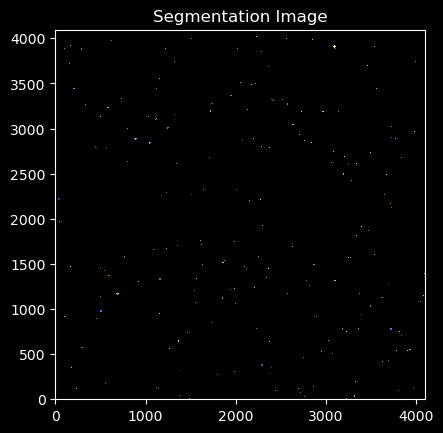

In [172]:
#CREATING A SEGMENTATION MAP OF ALL THE SOURCES GREATER THAN 2 SIGMA ABOVE 2D-BACKGROUND FOR B-FILTER
 
thresholdB = 10 * bkgB.background_rms
#The standard deviation of the background sky (from your earlier background estimation) = bkgB.background_rms
#Multiplying by 10 sets a detection threshold: only pixels that are 10σ above the background will be considered as part of sources.
#This is a high threshold, used to detect only bright sources.


kernel = make_2dgaussian_kernel(3.0, size=3)  # FWHM = 3.0
#Creates a 2D Gaussian kernel for convolution. Used to smooth the image slightly to make source detection more robust.


convolved_dataB = convolve(dataB, kernel)
segment_mapB = detect_sources(convolved_dataB, thresholdB, npixels=20)

#-----------------------------------------------------------------------------------------

norm = ImageNormalize(stretch=SqrtStretch())
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
plt.imshow(dataB, origin='lower', cmap='Greys_r', norm=norm )
plt.title('Background-subtracted Data')

#-----------------------------------------------------------------------------------------

plt.imshow(segment_mapB, origin='lower', cmap=segment_mapB.cmap, interpolation='nearest')
plt.title('Segmentation Image')
#plt.savefig('segmentation4.pdf')
plt.show()


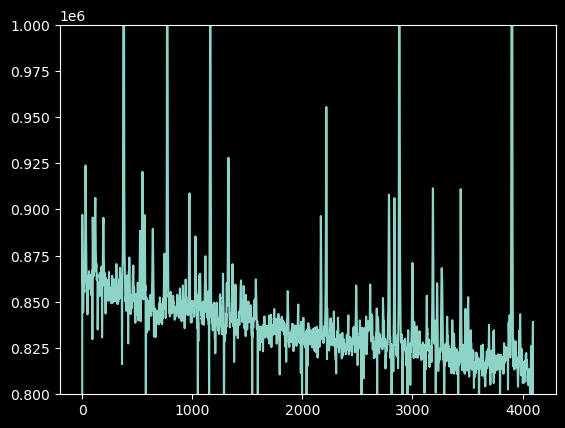

In [173]:
plt.plot(np.sum(convolved_dataB, axis = 1))
plt.ylim(0.8e06, 1e06)
plt.show()

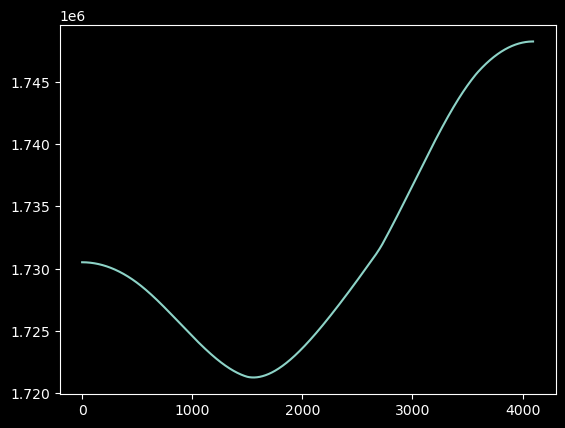

In [174]:
plt.plot(np.sum(thresholdB, axis = 0))
plt.show()

Deblending:   0%|          | 0/239 [00:00<?, ?it/s]

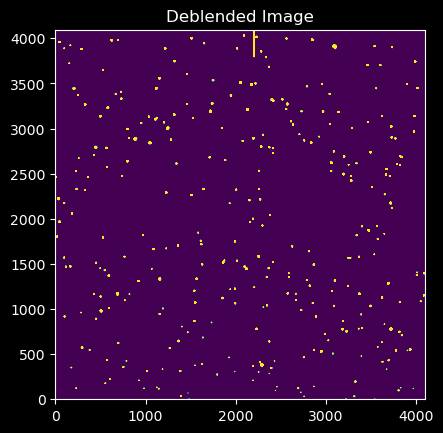

In [175]:
#SOURCE DEBLENDING FOR B-FILTER

segm_deblendB = deblend_sources(dataB, segment_mapB, npixels=20, nlevels=32, contrast=0.001, progress_bar=True)
#take a segmentation map where multiple sources may overlap and split them into separate objects.

plt.imshow(segm_deblendB ,  vmin = 0, vmax = 1) 
plt.gca().invert_yaxis()
plt.title('Deblended Image')
#plt.savefig('deblended5.pdf')
plt.show()

In [176]:
#SUBTRACTING 2D IMAGE FROM SCIENCE IMAGE FOR B-FILTER

newscienceB = dataB - bkgB.background


In [177]:
#CREATING SOURCE CATALOGUE FOR B-FILTER

bkgB_error = bkgB.background_rms
errorB = photutils.utils.calc_total_error(newscienceB, bkgB_error, 2.2)
catalogB = photutils.segmentation.SourceCatalog(newscienceB, segment_mapB, convolved_data=convolved_dataB, error= errorB, mask=None, background=bkgB.background, wcs= None, localbkg_width=0, apermask_method='correct', kron_params=(2.5, 1.4, 0.0), detection_cat=None, progress_bar=True)
tblB = catalogB.to_table(columns=('xcentroid', 'ycentroid','area', 'segment_flux', 'segment_fluxerr', 'area', 'ellipticity', 'orientation'))
print(tblB)

    xcentroid          ycentroid       area ...  segment_fluxerr       ellipticity         orientation    
                                       pix2 ...                                                deg        
------------------ ------------------ ----- ... ------------------ ------------------- -------------------
1485.4829770870417 1.8625301341308904 105.0 ...  495.6265010969835 0.47967530744184506  0.7865290086226995
 3220.619342363424 3.0639784736535858  85.0 ...  428.4020854131821  0.2736526509557853   4.055413273833857
 3539.627064707195 5.5125969995599515  33.0 ...  253.8376462448779 0.06259092528099508   7.677185510832192
 3312.671091302995 30.708766287094907 225.0 ...  749.6828194923698 0.10936170632612174   12.26403266667938
2758.0519010157004 28.897747131685325  79.0 ... 398.77758737236843 0.18828504661221268  11.527509537242546
1393.3440646557904  34.85183495083878 131.0 ...  524.7108107116816 0.13878819100692286  -6.627049893680372
  1471.78327790871  65.91118986878777

SOURCE EXTRACTION FOR R-FILTER

In [178]:
#GETTING IMAGE DIMENSIONS

dataR = frame_135R.data
# Get the shape (dimensions)
print("Image dimensions:", dataR.shape)

Image dimensions: (4096, 4096)


In [179]:
#BASIC STATISTICS

meanR0, medianR0, stdR0 = sigma_clipped_stats(dataR, sigma=5.0)
print(np.array((meanR0, medianR0, stdR0)))

#-------------------------------------------------------------------------

sigma_clip = SigmaClip(sigma=5.0, maxiters=20)
thresholdR = detect_threshold(dataR, nsigma=2.0, sigma_clip=sigma_clip)
segment_imgR = detect_sources(dataR, thresholdR, npixels=20)
# footprint = circular_footprint(radius=10)
# mask = segment_imgR.make_source_mask(footprint=footprint)
# meanR1, medianR1, stdR1 = sigma_clipped_stats(dataR, sigma=5.0, mask=mask)
# print(np.array((meanR1, medianR1, stdR1)))

[645.77839003 645.16024202  38.89907192]


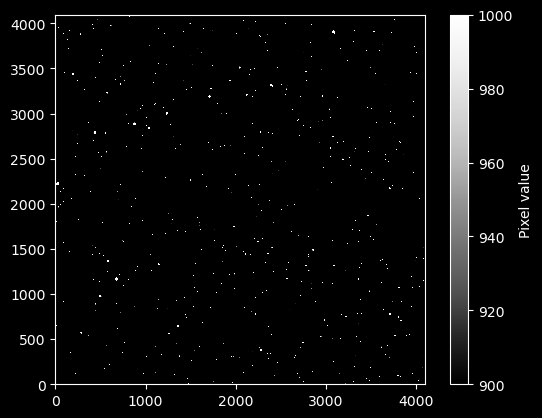

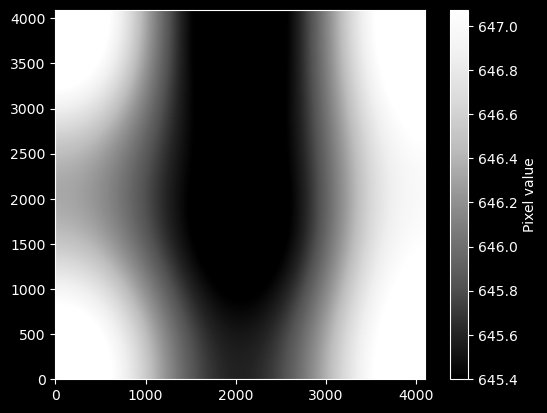

The Background Median for the R-Filter is 646.051
The Background RMS for the R-Filter is 38.896


In [180]:
#CREATING BACKGROUND FOR R-FILTER

#vmin0, vmax0 = np.percentile(data, (1, 99))
plt.imshow(dataR, origin='lower', cmap='Greys_r', interpolation='nearest', vmin = 900, vmax = 1000)
plt.colorbar(label='Pixel value') 
plt.show()
#-----------------------------------------------------------------------------------------------

bkgR_estimator = MedianBackground()
bkgR = Background2D(dataR, (1024, 1024), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkgR_estimator)

vmin, vmax = np.percentile(bkgR.background, (1, 99))
plt.imshow(bkgR.background, origin='lower', cmap='Greys_r',interpolation='nearest', vmin = vmin, vmax = vmax )
plt.colorbar(label='Pixel value') 
#plt.savefig('Background2D3.PDF')
plt.show()

print(f"The Background Median for the R-Filter is {bkgR.background_median:.3f}")
print(f"The Background RMS for the R-Filter is {bkgR.background_rms_median:.3f}")

1166.9643889417302


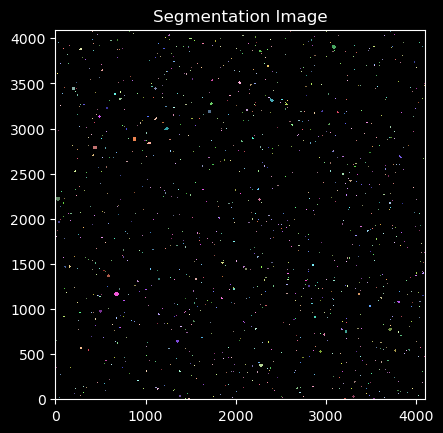

In [181]:
#CREATING A SEGMENTATION MAP OF ALL THE SOURCES GREATER THAN 9 SIGMA ABOVE 2D-BACKGROUND FOR R-FILTER
 
thresholdR2 = 30 * bkgR.background_rms
#thresholdR = bkgR.background_median + bkgR.background_rms
print(np.median(thresholdR2))
kernel = make_2dgaussian_kernel(3.0, size= 3)  # FWHM = 3.0
convolved_dataR = convolve(dataR, kernel)
segment_mapR = detect_sources(convolved_dataR, thresholdR, npixels=20)

#-----------------------------------------------------------------------------------------

norm = ImageNormalize(stretch=SqrtStretch())
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
plt.imshow(dataR, origin='lower', cmap='Greys_r', norm=norm, )
plt.title('Background-subtracted Data')

#-----------------------------------------------------------------------------------------

plt.imshow(segment_mapR, origin='lower', cmap=segment_mapR.cmap, interpolation='nearest')
plt.title('Segmentation Image')
#plt.savefig('segmentation4.pdf')
plt.show()

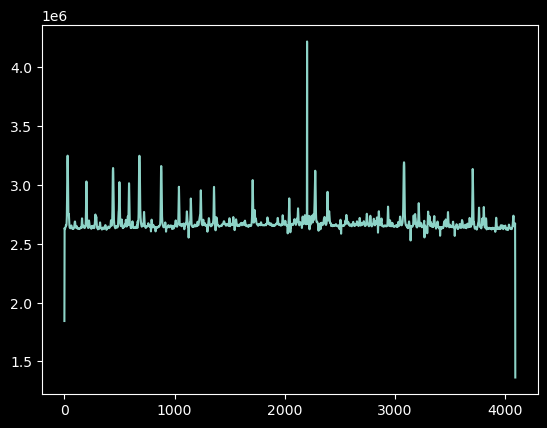

In [182]:
plt.plot(np.sum(convolved_dataR, axis = 0))
plt.show()

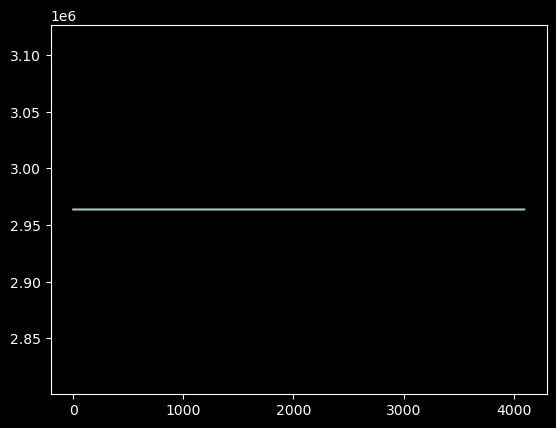

In [183]:
plt.plot(np.sum(thresholdR, axis = 0))
plt.show()

Deblending:   0%|          | 0/1938 [00:00<?, ?it/s]

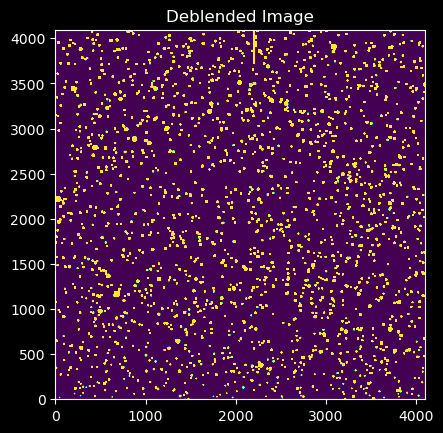

In [184]:
#SOURCE DEBLENDING

segm_deblendR = deblend_sources(dataR, segment_mapR, npixels=10, nlevels=32, contrast=0.001, progress_bar=True)

plt.imshow(segm_deblendR, origin='lower',  vmin = 0, vmax = 1) 
plt.title('Deblended Image')
#plt.savefig('deblended5.pdf')
plt.show()

In [185]:
#SUBTRACTING 2D IMAGE FROM SCIENCE IMAGE FOR R-FILTER

newscienceR = dataR - bkgR.background


In [186]:
#CREATING SOURCE CATALOGUE FOR R-FILTER

bkgR_error = bkgR.background_rms
errorR = photutils.utils.calc_total_error(newscienceR, bkgR_error, 2.2)
catalogR = photutils.segmentation.SourceCatalog(newscienceR, segment_mapR, convolved_data=convolved_dataR, error= errorR, mask=None, background=bkgR.background, wcs= None, localbkg_width=0, apermask_method='correct', kron_params=(2.5, 1.4, 0.0), detection_cat=None, progress_bar=True)
tblR = catalogR.to_table(columns=('xcentroid', 'ycentroid','area', 'segment_flux', 'segment_fluxerr', 'area', 'ellipticity', 'orientation', 'eccentricity'))
print(tblR)

    xcentroid          ycentroid       area ...     ellipticity          orientation         eccentricity   
                                       pix2 ...                              deg                            
------------------ ------------------ ----- ... -------------------- ------------------- -------------------
 1439.137194953457  2.755607031214515  87.0 ...  0.31842463639790053 -1.1725615517320547  0.7317479236257974
1476.8325858354565  3.071074130796269 186.0 ...   0.5242514718586161  0.8818833495354751  0.8795813424415657
3211.4484569050924 2.7497651097245734 142.0 ...   0.3545206594610113  1.4085615025866332   0.763777730061143
3527.7133426785695 3.7020330679536912 179.0 ...   0.6051413431133832   6.034521899625699  0.9187418794643559
2514.7727606776284  13.82610912903559  88.0 ...   0.0997854398540442   -30.0883477695888  0.4354466048796607
3642.2208410397625 15.886633488785355 109.0 ...  0.19948863078193035  -49.41523630756416  0.5993175683663974
1966.3837425556312 

PLOTTING THE COLOUR MAGNITUDE DIAGRAM (17/11/2025)

THIS FINDS THE POINT SOURCES IN THE RED FILTER DATA AND THEN CREATES A TABLE WHICH HAS THEI FLUX AND MAGNITUDE. WE CAN USE THIS TO CREATE A MEDIAN ZERO POINT OF ALL THE STARS WHICH CREATES A ZERO PPOINT WE CAN USE TO COMPUTE THE APPARENT MAGNITUDES OF THE GALAXY CLUSTERS.

What this table is telling me that the magnitudes are the instrumental magnitudes created from the flux, we need the apparent magnitudes and we need a zero point for that.

We can use the relationship between flux, instrumental magnitude and Zero point for that but we need to use kron flux sources in the data above and the instrumental magnitude in the sourcesB table and find an average zp, then we can use that zp to find the  apparent magnitude. BUT we must use catalogued magnitudes of stars before we use the galaxy flux

We found that it's possible to plot the diagram without absolute magnitude and just plot a difference of instrumental magnitudes against just 1 magnitude. This works in our favour concerning the time spent creating our data etc.

In [187]:
#INSTRUMENTAL MAGNITUDES FOR THE GALAXY CLUSTER IN B-FILTER AND R-FILTER; COMPTING COLOUR


tblR['m_instr'] = -2.5 * np.log10(tblR['segment_flux'])
tblB['m_instr'] = -2.5 * np.log10(tblB['segment_flux']) # computing instrumental magnitude

magR = np.asarray(tblR['m_instr'])
magB = np.asarray(tblB['m_instr']) # creating array so i can include it in my source catalog


tblB['mag_B'] = magB

tblR['mag_R'] = magR

#-------------------------------------------------------------

m = min(len(magR), len(magB)) # to match the lengths of the instrumental magnitude arrays so that i can subtract them for colour calcultion
magR = magR[:m]
magB = magB[:m]

colour = magB - magR # colour values

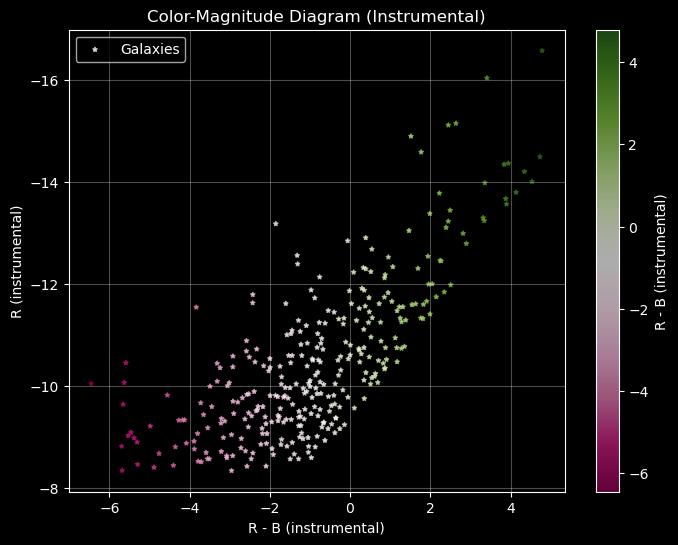

In [188]:
#PLOTTING THE COLOUR MAGNITUDE DIAGRAM

plt.style.use('dark_background') # made it easier to see my data points
plt.figure(figsize=(8,6))
plt.scatter(colour, magR, marker = '*', s=10, c = colour, cmap = 'PiYG', alpha=0.7, label = 'Galaxies')
#plt.colorbar(label = 'Number of Stars')
plt.gca().invert_yaxis()# magnitudes: brighter on top
plt.xlabel('R - B (instrumental)')
plt.ylabel('R (instrumental)')
plt.title('Color-Magnitude Diagram (Instrumental)')
plt.grid(color = 'white', alpha = 0.3)
plt.colorbar(label = 'R - B (instrumental)')
plt.legend()
plt.show()


NOW WE ARE PLOTTING THE ISOCHRONE DATA TO MEASURE THE AGES OF THE GALAXIES

In [189]:
#CALLING THE ISOCHRONE DATA AND RENAMING THE COLUMN TITLES

isoc = r'U:\Lab Book\Abell2319\science_B\output70820233159.txt'
isoc_tbl = pd.read_csv(isoc, sep='\s+', comment = '#')
#print(isoc_tbl)
#-----------------------------------------------------------------------

isoc_tbl.rename(columns = {isoc_tbl.columns[7]: "Log(T_eff)", isoc_tbl.columns[28]: "B mag", isoc_tbl.columns[30]: "R mag", isoc_tbl.columns[2]: "Log(Age)"}, inplace = True)
#print(isoc_tbl[[ "Log(T_eff)", "B mag", "R mag", "Log(Age)"]])

isoc_tbl['Colour'] = isoc_tbl["B mag"] - isoc_tbl["R mag"]

log_teff = isoc_tbl.iloc[:,7].values
T_eff = 10**(isoc_tbl["Log(T_eff)"])
#print(T_eff)



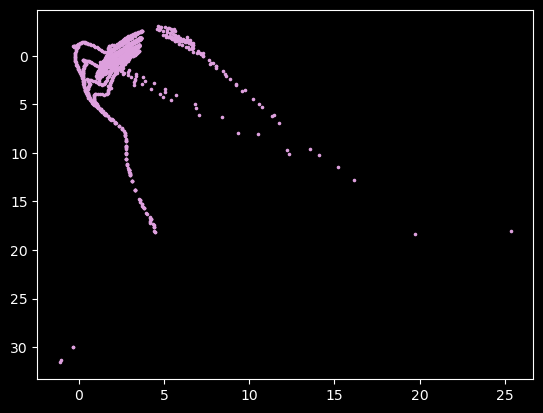

In [190]:
#PLOTTING THE ISOCHRONE DATA

plt.style.use('dark_background')
plt.scatter(isoc_tbl['Colour'], isoc_tbl["R mag"], color = 'plum', s = 10, label = 'Isochrone', marker = '.')
plt.gca().invert_yaxis()
plt.show()

THIS GRAPH SHOWS ALL THE ISOCHRONES FROM THE DATA ALL FROM ONE GRAPH, WE NOW WANT TO SPLIT THEM UP SO WE CAN PLOT ALL OF THEM SEPERATELY ONTO OUR CMD.

WE FOUND OUT THAT PLOTTING ISOCHRONES WOULD NOT BE BENEFICIAL FOR FINDING THE AGE OF THE UNIVERSE AS ISOCHRONES USE GLOBULAR CLUSTERS AS A FOCAL POINT AND STARS AND GALAXIES AGE DIFFERENTLY AND THEIR AGES ARE CHATEGORIZED DIFFERENTLY.

SO WE ARE DECIDING TO MAKE INFERENCES FROM DATA WE ALREADY HAVE AND WE THINK USING THE POSITIONS OF THE GALAXIES IN THE GALAXY CLUSTER AS A POINTER TO SEE STELLAR PRODUCTION. TO DO THIS WE WILL USE THE X AND Y CENTROID VALUYES IN THE SOURCE CATALOG TABLE AND PLOT THEM AGAINST EACH OTHER. THEN WE WILL AVERAGE THEM TO FIND THE CENTRE AND PLOT IT.

Dimmest galaxy for R-Band:
  magnitude = -8.149039219123559
  position  = (2382.620279506304, 1775.6635391321104)
Brightest galaxy for R-Band:
  magnitude = -17.13406686426345
  position  = (681.6353020903597, 1161.014808422353)


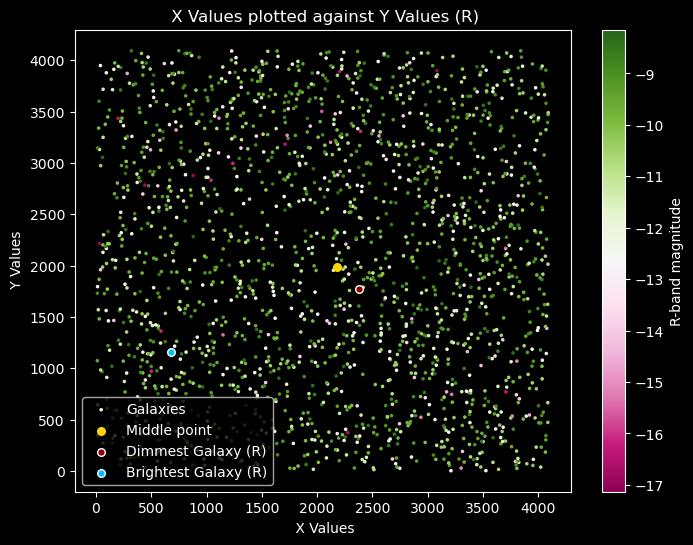

Dimmest galaxy for B-Band:
  magnitude = -9.301251324443914
  position  = (1940.7000566299323, 1213.9596385172867)
Brightest galaxy for B-Band:
  magnitude = -16.501315005201157
  position  = (3093.5053854174685, 3902.666076155213)


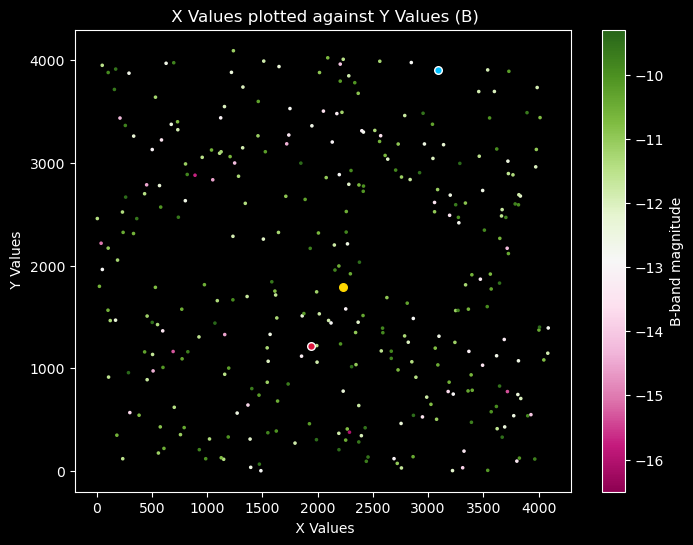

In [191]:
#GETTING DIMMEST GALAXY AMD ADDING TO PLOT BELOW (FOR R-BAND) 

idx = np.argmax(tblR['mag_R']) # finding minimum and maximum magnitude values for brightest and dimmest stars in r band
ind = np.argmin(tblR['mag_R'])
                
x_dim = tblR['xcentroid'][idx]
y_dim = tblR['ycentroid'][idx]

dimmest_mag = tblR['mag_R'].max()

x_br = tblR['xcentroid'][ind]
y_br = tblR['ycentroid'][ind]

brightest_mag = tblR['mag_R'].min()

print("Dimmest galaxy for R-Band:")
print(f"  magnitude = {dimmest_mag}")
print(f"  position  = ({x_dim}, {y_dim})")

print("Brightest galaxy for R-Band:")
print(f"  magnitude = {brightest_mag}")
print(f"  position  = ({x_br}, {y_br})")

#PLOTTING THE X AND Y CENTROID VALUES FOR R BAND VALUES

x = tblR['xcentroid']
y = tblR['ycentroid'] # has all the x and y positions of data points to plot so we can observe the spread from the middle point

medx = np.median(tblR['xcentroid'])
medy = np.median(tblR['ycentroid']) # middle point calculation

plt.style.use('dark_background')
plt.figure(figsize=(8,6))
xy = plt.scatter(x , y, c=tblR['mag_R'], cmap='PiYG', s = 10, marker = '.', label = 'Galaxies')
plt.scatter(medx, medy, s = 30, color = 'gold', marker = 'o', label = 'Middle point')
plt.scatter(x_dim, y_dim, s = 30, color = 'darkred', edgecolor='white', linewidth=1, marker = 'o', label = 'Dimmest Galaxy (R)')
plt.scatter(x_br, y_br, s = 30, color = 'deepskyblue', edgecolor='white', linewidth=1, marker = 'o', label = 'Brightest Galaxy (R)')
plt.colorbar(xy, label='R-band magnitude')
plt.title(' X Values plotted against Y Values (R)')
plt.xlabel(' X Values')
plt.ylabel(' Y Values')
plt.legend()
plt.show()

#-----------------------------------------------------------------------------------------------------------
#GETTING DIMMEST GALAXY AMD ADDING TO PLOT BELOW (FOR B-BAND) 

idxB = np.argmax(tblB['mag_B'])  
indB = np.argmin(tblB['mag_B'])

x_dimB = tblB['xcentroid'][idxB]# finding minimum and maximum magnitude values for brightest and dimmest stars in b band
y_dimB = tblB['ycentroid'][idxB]

dimmest_magB = tblB['mag_B'].max()

x_brB = tblB['xcentroid'][indB]
y_brB = tblB['ycentroid'][indB]

brightest_magB = tblB['mag_B'].min()

print("Dimmest galaxy for B-Band:")
print(f"  magnitude = {dimmest_magB}")
print(f"  position  = ({x_dimB}, {y_dimB})")

print("Brightest galaxy for B-Band:")
print(f"  magnitude = {brightest_magB}")
print(f"  position  = ({x_brB}, {y_brB})")

#PLOTTING THE X AND Y CENTROID VALUES FOR B-BAND VALUES

s = tblB['xcentroid']
t = tblB['ycentroid']

meds = np.median(tblB['xcentroid'])
medt = np.median(tblB['ycentroid'])


plt.figure(figsize=(8,6))
st = plt.scatter(s , t, c=tblB['mag_B'], cmap='PiYG', s = 10, marker = '.', label = 'Galaxies')
plt.scatter(meds, medt, s = 30, color = 'gold', marker = 'o', label = 'Middle point')
plt.scatter(x_dimB, y_dimB, s = 30, color = 'crimson', edgecolor='white', linewidth=1, marker = 'o', label = 'Dimmest Galaxy (B)')
plt.scatter(x_brB, y_brB, s = 30, color = 'deepskyblue', edgecolor='white', linewidth=1, marker = 'o', label = 'Brightest Galaxy (B)')
plt.colorbar(st, label='B-band magnitude')
plt.title(' X Values plotted against Y Values (B)')
plt.xlabel(' X Values')
plt.ylabel(' Y Values')
#plt.legend()
plt.show()

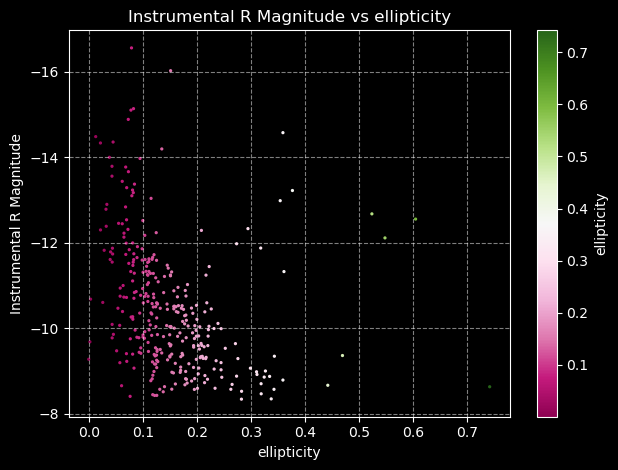

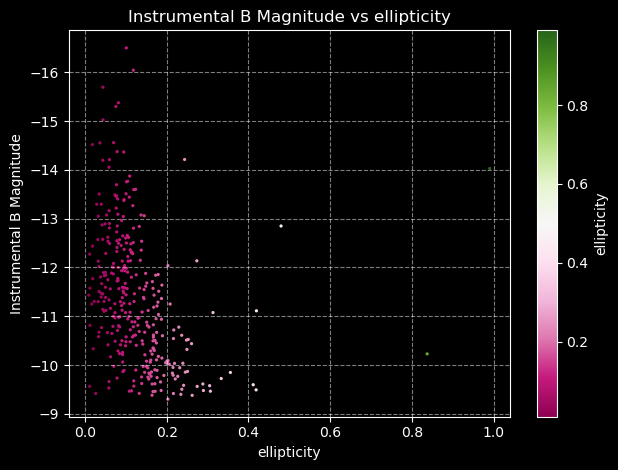

In [192]:
ellipticityR = tblR['ellipticity']

# Removing invalid or non-finite values
# mask = np.isfinite(magR) & np.isfinite(ellipticityR)
# mag_R = magR[mask]
# ellipticity_R = ellipticityR[mask]
m = min(len(magR), len(ellipticityR)) # to match the lengths of the instrumental magnitude and ellipticity
magR = magR[:m]
ellipticityR = ellipticityR[:m]

plt.scatter(ellipticityR, magR, s=7, c=ellipticityR, cmap='PiYG', marker = '.', alpha=1)
plt.gca().invert_yaxis()  # Bright = up
plt.xlabel('ellipticity')
plt.ylabel('Instrumental R Magnitude')
plt.title('Instrumental R Magnitude vs ellipticity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='ellipticity')
#plt.legend()
plt.tight_layout()
#plt.savefig('mag_vs_ellipticity2.pdf', dpi=300)
plt.show()

#------------------------------------------------------------------------------------------------

ellipticityB = tblB['ellipticity']

# Removing invalid or non-finite values
# mask = np.isfinite(magR) & np.isfinite(ellipticityR)
# mag_R = magR[mask]
# ellipticity_R = ellipticityR[mask]
mB = min(len(magB), len(ellipticityB)) # to match the lengths of the instrumental magnitude arrays so that i can subtract them for colour calcultion
magB = magB[:mB]
ellipticityB = ellipticityB[:mB]

plt.scatter(ellipticityB, magB, s=7, c=ellipticityB, cmap='PiYG', marker = '.', alpha=1)
plt.gca().invert_yaxis()  # Bright = up
plt.xlabel('ellipticity')
plt.ylabel('Instrumental B Magnitude')
plt.title('Instrumental B Magnitude vs ellipticity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='ellipticity')
#plt.legend()
plt.tight_layout()
#plt.savefig('mag_vs_ellipticity2.pdf', dpi=300)
plt.show()

We used ellipticity because galaxies are shaped differently, so seeing light from differently shaped galaxies can help us see how they correlate. In both bands, we can see that very round galaxies have a large spread of magntiudes but as their ellipticity increases, the magnitude decreasews. We expect this as not all galaxies are observed face on, so we record less light from them. This could give us false values in our data when we look at brightest and dimmest galaxies. There could be galaxies that are titled, especially spiral galaxies, that look dimmer but are actually bright. This is due to things like dust and how surface brightness changes due to projection. If the galaxy is tilted, light has to travel through the dust on the edge of the galaxy, making it appear redder and dimmer. So a bright galaxy could appear red if we are not observing face on.

PLOTTING A 2D DENSITY ESTIMATION OF ABELL 2319 IN THE R AND B BANDS

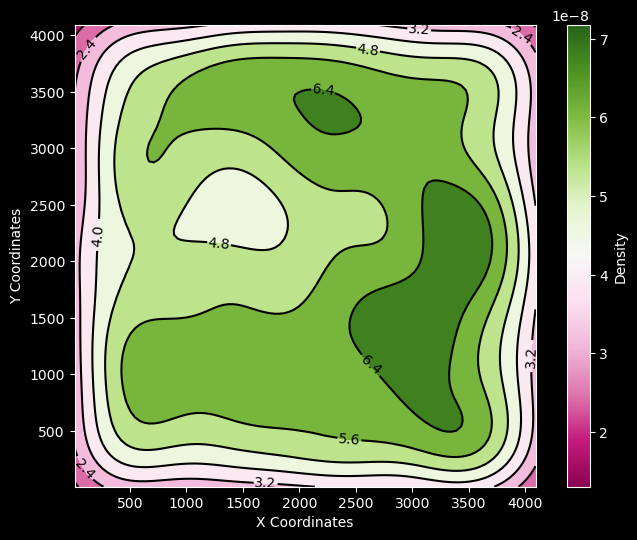

In [193]:
# Source - https://stackoverflow.com/a
# Posted by Flabetvibes, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-27, License - CC BY-SA 3.0

x = tblR['xcentroid']
y = tblR['ycentroid']
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

#Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] 
#creates a 2D grid of points, 100 points along each axis
#xx and yy are 2D arrays giving the coordinates of every point in the grid.

positions = np.vstack([xx.ravel(), yy.ravel()])
#xx.ravel() and yy.ravel() flatten the 2D grid arrays into 1D arrays.
#np.vstack([xx.ravel(), yy.ravel()]) stacks them into shape (2, Ngrid) for evaluation.

values = np.vstack([x, y])
#Stacks the galaxy coordinates into a 2D array of shape (2, Ngalaxies).
#values is the input dataset for the KDE.


kernel = stats.gaussian_kde(values)
#gaussian_kde(values) creates a kernel density estimator of your galaxy positions.
#The kernel is Gaussian (smooths each galaxy position).
#KDE estimates the local density of galaxies at any point in the field.


f = np.reshape(kernel(positions).T, xx.shape)
#kernel(positions) → evaluates the density at each grid point (1D array of length 100*100).
#.T transposes for correct shape (optional, depends on implementation).
#np.reshape(..., xx.shape) → reshapes the 1D array back to a 2D array matching the grid.


#--------------------------------------------------------------------------


fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='PiYG')
## Or kernel density estimate plot instead of the contourf plot
img = ax.imshow(np.rot90(f), cmap='PiYG', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')

ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
cbar = plt.colorbar(img, ax=ax)
cbar.set_label("Density")

plt.show()


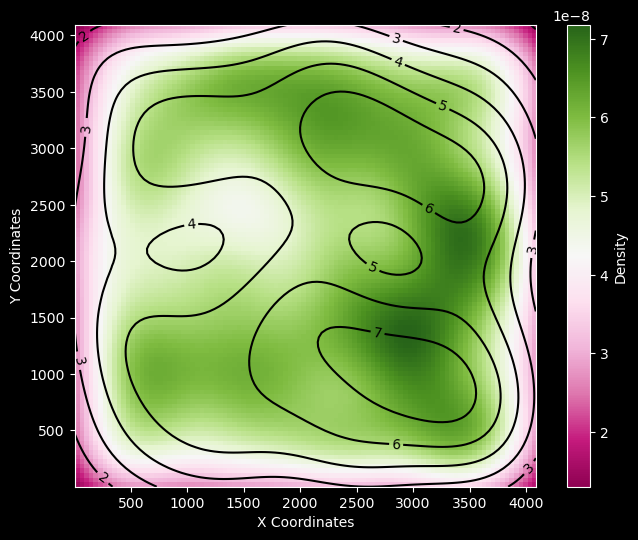

In [194]:
xB = tblB['xcentroid']
yB = tblB['ycentroid']
xBmin, xBmax = xB.min(), xB.max()
yBmin, yBmax = yB.min(), yB.max()

#Peform the kernel density estimate
xxB, yyB = np.mgrid[xBmin:xBmax:100j, yBmin:yBmax:100j]
positionsB = np.vstack([xxB.ravel(), yyB.ravel()])
valuesB = np.vstack([xB, yB])
kernel = stats.gaussian_kde(valuesB)
fB = np.reshape(kernel(positionsB).T, xxB.shape)

#--------------------------------------------------------------------------

fig = plt.figure(figsize=(8,6))
axB = fig.gca()
axB.set_xlim(xBmin, xBmax)
axB.set_ylim(yBmin, yBmax)
# Contourf plot
cfsetB = ax.contourf(xxB, yyB, fB, cmap='PiYG')
## Or kernel density estimate plot instead of the contourf plot
img = axB.imshow(np.rot90(f), cmap='PiYG', extent=[xBmin, xBmax, yBmin, yBmax])
# Contour plot
csetB = axB.contour(xxB, yyB, fB, colors='k')

axB.clabel(csetB, inline=0.5, fontsize=10)
axB.set_xlabel('X Coordinates')
axB.set_ylabel('Y Coordinates')
cbar = plt.colorbar(img, ax=axB)
cbar.set_label("Density")

plt.show()